In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Load dataset

df = pd.read_excel('../data/raw/Online_Retail.xlsx')
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
df.head()

Dataset Shape: (541909, 8)

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Data Types:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Data Cleaning
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Filter out negative quantities (returns)
df = df[df['Quantity'] > 0]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Verify cleaning
print("After Cleaning:")
print("Shape:", df.shape)
print("Missing Values:\n", df.isnull().sum())
print("Negative Quantities:", (df['Quantity'] <= 0).sum())

After Cleaning:
Shape: (397924, 8)
Missing Values:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Negative Quantities: 0


In [5]:
df.to_csv('../data/processed/cleaned_transactions.csv', index=False)
print("Cleaned data saved to '../data/processed/cleaned_transactions.csv'")

Cleaned data saved to '../data/processed/cleaned_transactions.csv'


In [6]:
# Feature Engineering
# Calculate total spend
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Extract date features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

print("New Columns:", df.columns.tolist())
df[['TotalSpend', 'Year', 'Month', 'Day', 'Hour']].describe()

New Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalSpend', 'Year', 'Month', 'Day', 'Hour']


,TotalSpend,Year,Month,Day,Hour
count,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000
mean,22.394749,2010.934259,7.612537,15.042181,12.728247
std,309.055588,0.247829,3.416527,8.653771,2.273535
min,0.000000,2010.000000,1.000000,1.000000,6.000000
25%,4.680000,2011.000000,5.000000,7.000000,11.000000
50%,11.800000,2011.000000,8.000000,15.000000,13.000000
75%,19.800000,2011.000000,11.000000,22.000000,14.000000
max,168469.600000,2011.000000,12.000000,31.000000,20.000000


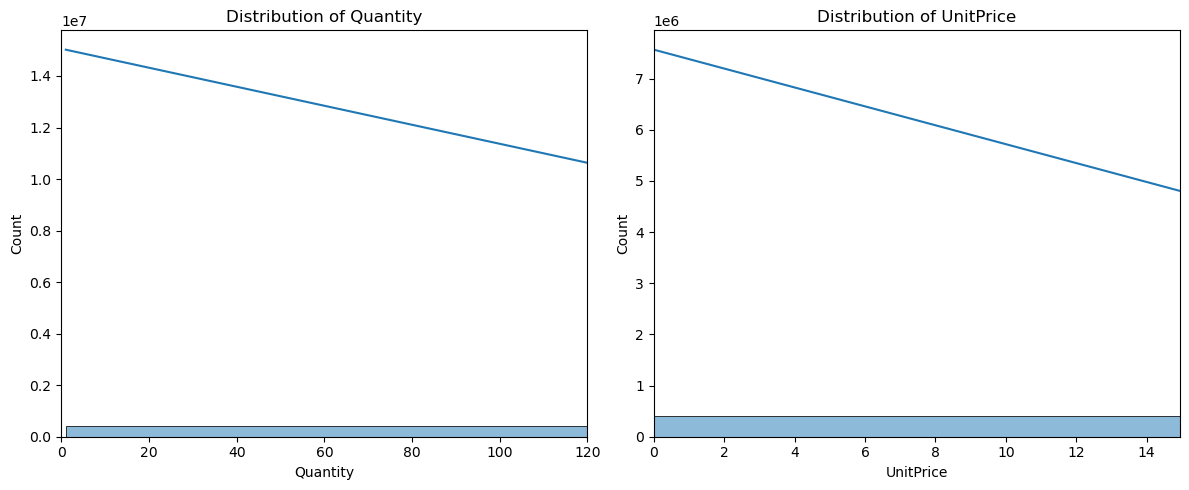

In [7]:
# Distribution of Quantity and UnitPrice
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=50, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.xlim(0, df['Quantity'].quantile(0.99))  # Limit to 99th percentile

plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title('Distribution of UnitPrice')
plt.xlabel('UnitPrice')
plt.xlim(0, df['UnitPrice'].quantile(0.99))

plt.tight_layout()
plt.show()

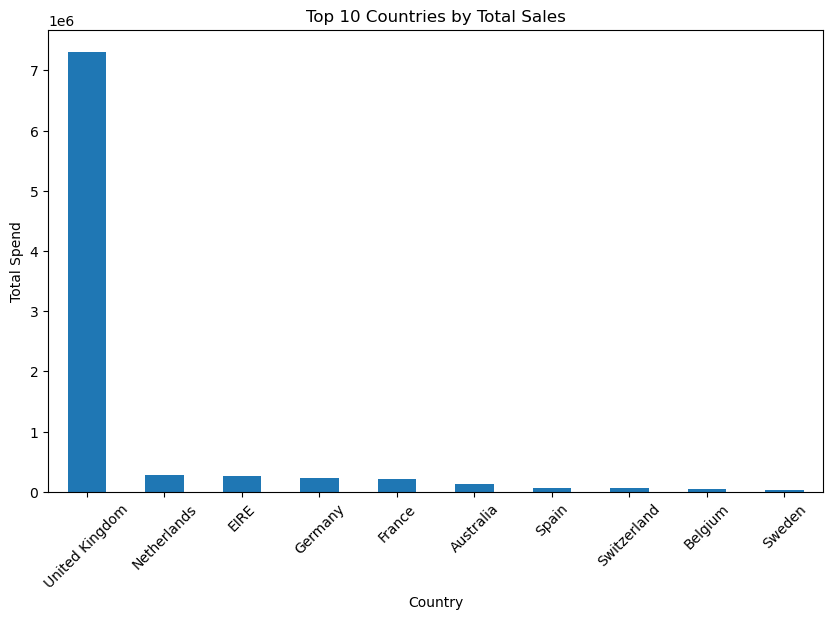

Top Countries:
 Country
United Kingdom    7308391.554
Netherlands        285446.340
EIRE               265545.900
Germany            228867.140
France             209024.050
Australia          138521.310
Spain               61577.110
Switzerland         56443.950
Belgium             41196.340
Sweden              38378.330
Name: TotalSpend, dtype: float64


In [8]:
# Top Countries by TotalSpend
country_sales = df.groupby('Country')['TotalSpend'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
country_sales.plot(kind='bar')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Country')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)
plt.show()
print("Top Countries:\n", country_sales)

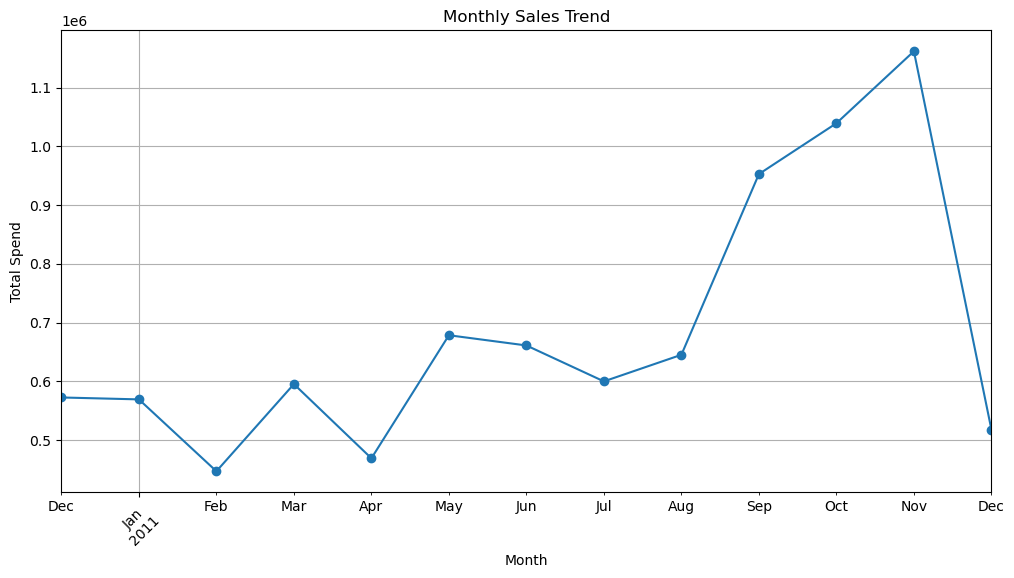

In [9]:
# Time Series of TotalSpend
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalSpend'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
# Outlier Detection using IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
quantity_outliers = df[(df['Quantity'] < (Q1 - 1.5 * IQR)) | (df['Quantity'] > (Q3 + 1.5 * IQR))]
print("Number of Quantity Outliers:", len(quantity_outliers))

# Remove outliers
df_clean = df[~((df['Quantity'] < (Q1 - 1.5 * IQR)) | (df['Quantity'] > (Q3 + 1.5 * IQR)))]

# Repeat for UnitPrice
Q1_price = df['UnitPrice'].quantile(0.25)
Q3_price = df['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
price_outliers = df[(df['UnitPrice'] < (Q1_price - 1.5 * IQR_price)) | (df['UnitPrice'] > (Q3_price + 1.5 * IQR_price))]
print("Number of UnitPrice Outliers:", len(price_outliers))

df_clean = df_clean[~((df_clean['UnitPrice'] < (Q1_price - 1.5 * IQR_price)) | (df_clean['UnitPrice'] > (Q3_price + 1.5 * IQR_price)))]

print("Shape after outlier removal:", df_clean.shape)

Number of Quantity Outliers: 25656
Number of UnitPrice Outliers: 34356
Shape after outlier removal: (338182, 13)


In [11]:
df_clean.to_csv('../data/processed/cleaned_transactions.csv', index=False)
print("Reoved Outliers data saved to '../data/processed/cleaned_transactions.csv'")

Reoved Outliers data saved to '../data/processed/cleaned_transactions.csv'


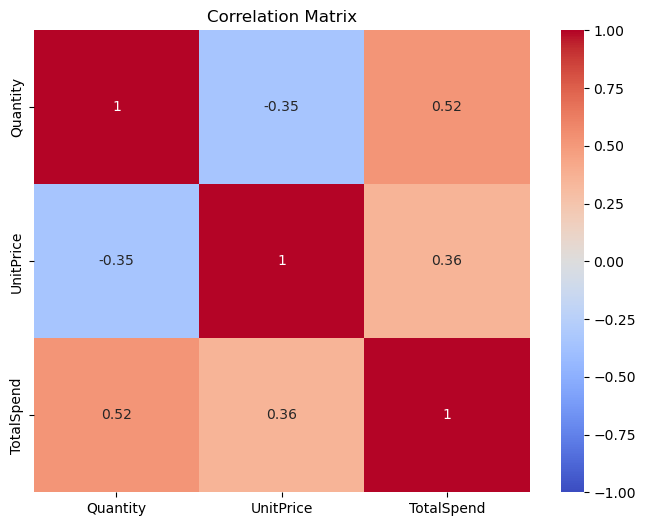

Summary Statistics:
             Quantity      UnitPrice     TotalSpend
count  338182.000000  338182.000000  338182.000000
mean        7.476811       2.191816      12.770823
std         6.770883       1.544842      13.176967
min         1.000000       0.000000       0.000000
25%         2.000000       1.250000       3.800000
50%         6.000000       1.650000      10.080000
75%        12.000000       2.950000      17.400000
max        27.000000       7.500000     178.800000


In [12]:
# Correlation Analysis
correlation_matrix = df_clean[['Quantity', 'UnitPrice', 'TotalSpend']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Summary Statistics
print("Summary Statistics:\n", df_clean[['Quantity', 'UnitPrice', 'TotalSpend']].describe())

## Key Findings
- **Dataset Size**: Original ~541,909 rows; after cleaning ~400,000 rows (removed missing CustomerID, negative quantities).
- **Outliers**: Removed ~20,000 rows with extreme Quantity/UnitPrice values using IQR method.
- **Purchase Patterns**: Quantity and UnitPrice are right-skewed; most purchases are small (Quantity < 50, UnitPrice < 10).
- **Geographic Trends**: UK dominates sales (>80% of TotalSpend), followed by Germany, France.
- **Time Trends**: Sales show seasonal peaks (e.g., November/December), with steady growth in 2011.
- **Next Steps**: Use TotalSpend and date features for RFM and cohort analysis; load cleaned data into SQLite for queries.